In [2]:
import os
import time
import uuid
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt 
import tensorflow as tf
import json
import albumentations as A

# Resizing Input Images using CV2

In [3]:

# # Directory containing the input images
# input_dir = "./data1/input_images"
# # Directory where resized images will be saved
# output_dir = "./data1/resized_img/"

# # Create the output directory if it doesn't exist
# if not os.path.exists(output_dir):
#     os.makedirs(output_dir)

# # List of image file names in the input directory
# image_files = os.listdir(input_dir)

# # Specify the new dimensions (width and height)
# new_width = 1024  # Set the desired width
# new_height = 768  # Set the desired height

# # Iterate over the image files and resize each one
# for image_file in image_files:
#     # Load the image
#     image_path = os.path.join(input_dir, image_file)
#     image = cv2.imread(image_path)

#     # Resize the image
#     resized_image = cv2.resize(image, (new_width, new_height))

#     # Save the resized image to the output directory
#     output_path = os.path.join(output_dir, image_file)
#     cv2.imwrite(output_path, resized_image)

#     print(f"Resized and saved: {output_path}")

# # Optionally, release any openCV resources if necessary
# cv2.destroyAllWindows()


# Split the dataset for train and test

In [95]:
# import os
# import random
# import shutil
# SOURCE_DIR = os.path.join('Dataset', 'images')
# size = len(os.listdir(SOURCE_DIR))
# print(size)
# TRAINING_DIR = os.path.join('Dataset', 'train','images')
# VALIDATION_DIR = os.path.join('Dataset', 'val','images')
# TESTING_DIR = os.path.join('Dataset', 'test','images')
# image_list = random.sample(os.listdir(SOURCE_DIR), len(os.listdir(SOURCE_DIR)))
# train_size = 70
# test_size = 29
# val_size = 30
# for i,image_name in enumerate(image_list):
#     # image paths
#     img_path = os.path.join(SOURCE_DIR,image_name)
#     train_path = os.path.join(TRAINING_DIR,image_name)
#     val_path = os.path.join(VALIDATION_DIR,image_name)
#     test_path = os.path.join(TESTING_DIR,image_name)

#     if os.path.getsize(img_path)==0:
#       print(image_name," filename is zero length, so ignoring.")
#     else:
#       if i < train_size:
#         shutil.copyfile(img_path,train_path)
#       elif train_size <= i and i < val_size+train_size:
#         shutil.copyfile(img_path,val_path)
#       else:
#         shutil.copyfile(img_path,test_path)


129



Adding labels of images in to respective folders.


In [96]:
# for folder in ['train','val','test']:
# 	for file in os.listdir(os.path.join('Dataset',folder,'images')):
    
# 		filename = file.split('.')[0]+'.json'
# 		existing_filepath = os.path.join('Dataset','labels',filename)
# 		if os.path.exists(existing_filepath):
# 			new_filepath = os.path.join('Dataset',folder,'labels',filename)
# 			shutil.copyfile(existing_filepath,new_filepath)
  

### Image Augmentation Composer function

In [97]:
augmentor = A.Compose(
    [
    A.RandomCrop(width=450, height=450),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.RGBShift(p=0.2),
    A.VerticalFlip(p=0.5),
    A.RandomGamma(p=0.2),
    ],
    bbox_params=A.BboxParams(format='albumentations', label_fields=['class_labels']),
    )


### Sample of Augmentation Pipeline with single img

In [8]:
img = cv2.imread(os.path.join('data1','train', 'images','IMG_0354.jpg'))
with open(os.path.join('data1','train', 'labels','IMG_0354.json'), 'r') as f:
    label = json.load(f)
label['shapes'][0]['points']

[[396.11214953271025, 276.9906542056075],
 [492.3738317757009, 334.93457943925233]]

In [9]:
img.shape

(768, 1024, 3)

In [10]:
coords = [0,0,0,0]
coords[0] = label['shapes'][0]['points'][0][0]
coords[1] = label['shapes'][0]['points'][0][1]
coords[2] = label['shapes'][0]['points'][1][0]
coords[3] = label['shapes'][0]['points'][1][1]
coords
coords = list(np.divide(coords, [1024,768,1024,768]))
coords

[0.38682827102803735,
 0.3606649143302181,
 0.48083382009345793,
 0.4361127336448598]

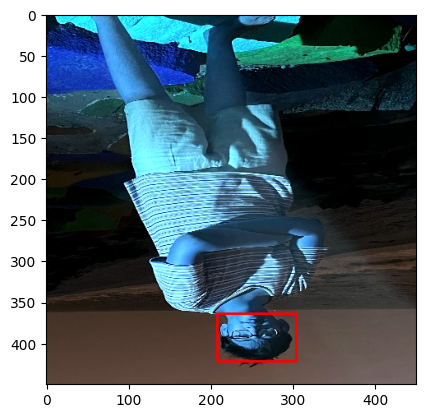

In [11]:
augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])
augmented['bboxes'][0][2:]
augmented['bboxes']
cv2.rectangle(augmented['image'], 
              tuple(np.multiply(augmented['bboxes'][0][:2], [450,450]).astype(int)),
              tuple(np.multiply(augmented['bboxes'][0][2:], [450,450]).astype(int)), 
                    (255,0,0), 2)

plt.imshow(augmented['image'])

# Build and Run a full scale Augmentation Pipeline

In [102]:
for partition in ['train','test','val']:
    for image in os.listdir(os.path.join('Dataset',partition,'images')):
        # Load the image
        img = cv2.imread(os.path.join('Dataset',partition, 'images', image))
        x,y = img.shape[1],img.shape[0]
        print(x,y)
        # Coordinates for bounded boxes in images with no annotations.
        coords = [0,0,0.00001,0.00001]
        # Load the label
        label_path = os.path.join('Dataset',partition,'labels',f'{image.split(".")[0]}.json')
        if os.path.exists(label_path):
            # uses a context manager to open the file as read only mode'r' and assign the file to f.
            with open(label_path,'r') as f:
                # read the content of file and convert it to json.
                label = json.load(f)

            coords[0] = label['shapes'][0]['points'][0][0]
            coords[1] = label['shapes'][0]['points'][0][1]
            coords[2] = label['shapes'][0]['points'][1][0]
            coords[3] = label['shapes'][0]['points'][1][1]
            coords = list(np.divide(coords, [ x, y, x, y]))
        try:
            for x in range(60):
                augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])
                # save the augmented image using imwrite
                cv2.imwrite(os.path.join('aug_data',partition,'images',f"{image.split('.')[0]}_{x}.jpg"),augmented['image'])
                annotations = {}
                #save image name in annotations dictionary
                annotations['image'] = image
                #save coordinates in annotations dictionary
                if os.path.exists(label_path):
                    if len(augmented['bboxes'])==0:
                        #if there is no bounding box in the image then set the coordinates to 0 and class to 0-> no BBox
                        annotations['bbox'] = [0,0,0,0]
                        annotations['class'] = 0
                    else:
                        #if there is bounding box in the image then set the coordinates to the bounding box and class to 1-> BBox
                        annotations['bbox'] = augmented['bboxes'][0]
                        annotations['class'] = 1
                else:
                    #if there is no bounding box in the image then set the coordinates to 0 and class to 0-> no BBox
                    annotations['bbox'] = [0,0,0,0]
                    annotations['class'] = 0
                path = os.path.join('aug_data',partition,'labels',f'{image.split(".")[0]}.{x}.json')
                # opening the file at path for writing 
                with open(path, 'w') as f:
                    # the content of the annotations dictionary will be serialized to JSON and saved in the specified file.
                    json.dump(annotations, f)
                    
        except Exception as e:
            print(e)

640 480
640 480
640 480
640 480
640 480
640 480
640 480
640 480
640 480
640 480
640 480
640 480
640 480
640 480
640 480
640 480
640 480
640 480
640 480
640 480
640 480
640 480
640 480
640 480
640 480
640 480
640 480
640 480
640 480
640 480
640 480
960 1706
831 1024
1024 768
768 1024
768 1024
1024 768
3024 4032
3024 4032
3024 4032
3024 4032
3024 4032
3024 4032
3024 4032
3024 4032
3024 4032
3024 4032
3024 4032
3024 4032
720 960
720 960
960 720
1944 2592
6912 9216
6912 9216
6120 8160
6144 6144
3456 4608
3456 4608
9216 6912
2320 3088
3024 4032
2316 3088
2642 4026
3024 4032
3024 4032
720 1280
720 1280
1280 720
1280 720
640 480
640 480
640 480
640 480
640 480
640 480
640 480
640 480
640 480
640 480
640 480
640 480
640 480
640 480
640 480
992 992
768 1024
768 1024
3024 4032
3024 4032
3024 4032
3024 4032
3024 4032
720 960
1080 1440
6912 9216
1440 1080
3024 4032
1280 720
640 480
640 480
640 480
640 480
640 480
640 480
640 480
640 480
640 480
640 480
640 480
640 480
640 480
960 1706
960 1280
127

### Loading images and labels for Train, Val, Test set

In [100]:
# load_image function is used to load the image from the file path
def load_image(x):
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [101]:
# dataset.list_files is used to get the list of files in the directory
train_images = tf.data.Dataset.list_files('aug_data\\train\\images\\*.jpg', shuffle=False)
# map function is used to apply the load_image function to each img file of the dataset
train_images = train_images.map(load_image)
# resizing the img
train_images = train_images.map(lambda x: tf.image.resize(x, (120,120)))
# normalizing the img
train_images = train_images.map(lambda x: x/255)

In [103]:
test_images = tf.data.Dataset.list_files('aug_data\\test\\images\\*.jpg', shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (120,120)))
test_images = test_images.map(lambda x: x/255)

In [104]:
val_images = tf.data.Dataset.list_files('aug_data\\val\\images\\*.jpg', shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (120,120)))
val_images = val_images.map(lambda x: x/255)

In [105]:
# image_data.as_numpy_iterator().next() is used to get the next image from a TensorFlow dataset object called image_data.
im = train_images.as_numpy_iterator().next()

In [106]:
# load_labels function is used to load the label from the file path
def load_labels(label_path):
    with open(label_path.numpy(), 'r',encoding="utf-8") as f:
        label = json.load(f)
    return [label['class']],label['bbox']

In [107]:
train_labels = tf.data.Dataset.list_files('aug_data\\train\\labels\\*.json', shuffle=False)
# x is element from train_labels list -> path to files.
train_labels = train_labels.map(lambda x: tf.py_function(func=load_labels, inp = [x], Tout=[tf.uint8, tf.float16]))
# tout is defining datatypes of the output of the function
# tf.py_function() is used to execute a Python function (load_labels) as part of a TensorFlow graph. It allows you to apply arbitrary Python code to the elements of a TensorFlow dataset.

In [108]:
test_labels = tf.data.Dataset.list_files('aug_data\\test\\labels\\*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(func=load_labels, inp = [x], Tout=[tf.uint8, tf.float16]))

In [21]:
val_labels = tf.data.Dataset.list_files('aug_data\\val\\labels\\*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(func=load_labels, inp = [x], Tout=[tf.uint8, tf.float16]))

In [109]:
print(len(train_images), 
len(train_labels), 
len(test_images), 
len(test_labels), 
len(val_images), 
len(val_labels))


4680 5220 2580 2580 2460 780


In [23]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(1000)
train = train.batch(8)
train = train.prefetch(4)

In [110]:

test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(500)
test = test.batch(8)
test = test.prefetch(4)

In [111]:

val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(500)
val = val.batch(8)
val = val.prefetch(4)

In [115]:
res = train.as_numpy_iterator().next()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


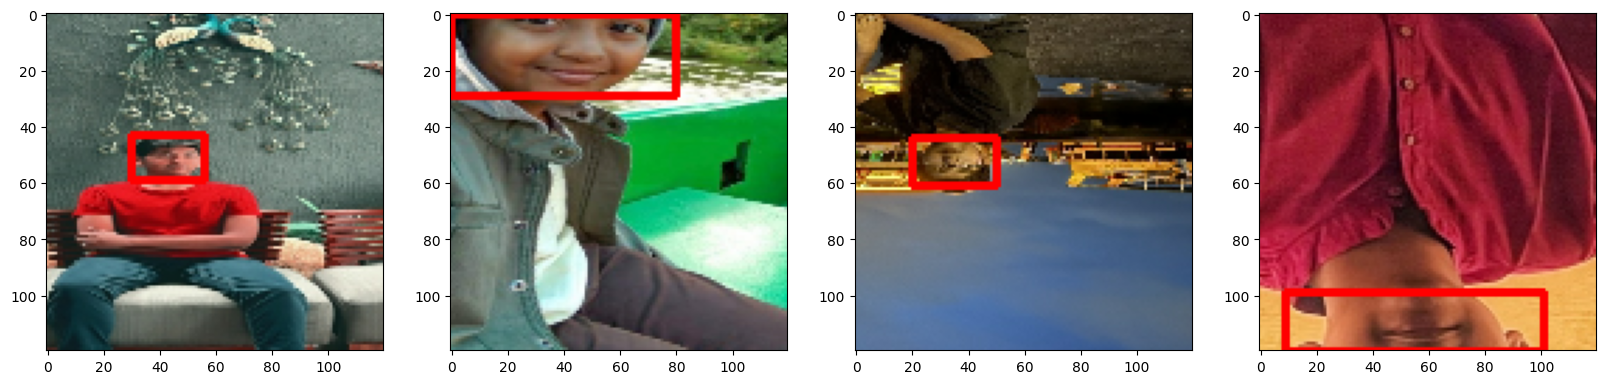

In [116]:
fig,ax = plt.subplots(ncols = 4, figsize = (20,20))
for i in range(4):
    sample_img = res[0][i]
    sample_coords = res[1][1][i]
    cv2.rectangle(
        sample_img, 
        tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)), 
        tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
        (255,0,0), 2)
    ax[i].imshow(sample_img)

# Build DL model using Functional API

In [36]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16

In [37]:
vgg = VGG16(include_top = False)
# include top get rid of the final layers in vgg16 model which classifies the image in last layers of model.

In [38]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [39]:
# we are using functional api instead of sequential api because there are 2 outputs.
input_layer = Input(shape=(120,120,3))
vgg = VGG16(include_top=False)(input_layer)

f1 = GlobalMaxPooling2D()(vgg)
class1 = Dense(2048,activation='relu')(f1)
class2 = Dense(1,activation='sigmoid')(class1)

f2 = GlobalMaxPooling2D()(vgg)
regress1 = Dense(2048,activation='relu')(f2)
regress2 = Dense(4,activation='sigmoid')(regress1)
# after vgg processes the data, we will have its output passed to 2 2 different dense layers for 2 different outputs
# 4 units will give the coordinbates of bbox.
faceTracker = Model(inputs = input_layer, outputs = [class2,regress2])
# we need 2 types of outputs -> classifiaction and regression
# classification gives the probability of the image being a face
# regression gives the coordinates of the face/ bounding box    

In [40]:
faceTracker.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 120, 120, 3)]        0         []                            
                                                                                                  
 vgg16 (Functional)          (None, None, None, 512)      1471468   ['input_2[0][0]']             
                                                          8                                       
                                                                                                  
 global_max_pooling2d (Glob  (None, 512)                  0         ['vgg16[0][0]']               
 alMaxPooling2D)                                                                                  
                                                                                              

In [41]:
x,y = train.as_numpy_iterator().next()
classes,coords = faceTracker.predict(x)
classes,coords
# for a batch of 8

1/1 [==============================] - 1s 547ms/step


(array([[0.46852297],
        [0.45370615],
        [0.4709843 ],
        [0.50415605],
        [0.49516934],
        [0.5441801 ],
        [0.5618026 ],
        [0.41719854]], dtype=float32),
 array([[0.40486357, 0.4180487 , 0.6107223 , 0.70022744],
        [0.39135984, 0.28548962, 0.59181184, 0.6873254 ],
        [0.3887036 , 0.28279462, 0.58594453, 0.6416372 ],
        [0.45633352, 0.4166623 , 0.52148545, 0.68572146],
        [0.347789  , 0.34980515, 0.5138212 , 0.7072665 ],
        [0.4066543 , 0.37426117, 0.53769344, 0.63458854],
        [0.540015  , 0.44237712, 0.6226948 , 0.64386606],
        [0.4103079 , 0.42554918, 0.5592222 , 0.73114264]], dtype=float32))

# Defining Losses & Optimizers

In [42]:
len(train)

300

In [43]:
batches_per_epoch = len(train)
lr_decay = (1./0.75-1)/batches_per_epoch
opt = tf.optimizers.legacy.Adam(learning_rate=0.0001,decay = lr_decay)
# learning rate controls the step size of the gradient descent
# decay is used to reduce the learning rate over time such that it improves convergence of training

In [44]:
lr_decay

0.001111111111111111

In [45]:
def localization_loss(ytrue,yhat):
    delta_coord = tf.reduce_sum(tf.square(ytrue[:,:2] - yhat[:,:2]))

    htrue = ytrue[:,3] - ytrue[:,1]
    wtrue = ytrue[:,2] - ytrue[:,0]
    hpred = yhat[:,3] - yhat[:,1]
    wpred = yhat[:,2] - yhat[:,0]	
    
    delta_size = tf.reduce_sum(tf.square(wtrue - wpred) + tf.square(htrue - hpred))

    return delta_coord + delta_size

In [46]:
class_loss = tf.keras.losses.BinaryCrossentropy()
regress_loss = localization_loss

In [47]:
print(localization_loss(y[1],coords).numpy())
class_loss(y[0],classes).numpy()

1.9139299


0.71855026

In [48]:
# Custom Keras Model Class
# subclassing the model class from keras -> parent class is tf.keras.Model
# this needs a init,compile, train_step and call method.
class FT(Model): 
    # passing inital params to model class, here we are passing our pre built nn. when we call FT, it will call the model class and pass the params to it.
    # super() is used to call the parent class.
    def __init__(self, eyetracker,**kwargs): 
        super().__init__(**kwargs)
        self.model = eyetracker
    #
    def compile(self, opt, classloss, localizationloss,**kwargs):
        super().compile(**kwargs)
        self.closs = classloss
        self.lloss = localizationloss
        self.opt = opt
    
    def train_step(self, batch,**kwargs): 
        
        X, y = batch
        
        with tf.GradientTape() as tape: 
            print("1: ",self.model(X))
            classes, coords = self.model(X)
            
            batch_classloss = self.closs(y[0], classes)
            batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
            
            total_loss = batch_localizationloss+0.5*batch_classloss
            
        grad = tape.gradient(total_loss, self.model.trainable_variables)
        
        opt.apply_gradients(zip(grad, self.model.trainable_variables))
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
    
    def test_step(self, batch, **kwargs): 
        X, y = batch
        
        classes, coords = self.model(X)
        
        batch_classloss = self.closs(y[0], classes)
        batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
        total_loss = batch_localizationloss+0.5*batch_classloss
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
        
    def call(self, X, **kwargs): 
        return self.model(X, **kwargs)

In [49]:
# Model object of FT Subclass
model = FT(faceTracker)

In [50]:
model.compile(opt, class_loss, regress_loss,metrics=["accuracy"])

In [51]:
logdir='logs'

In [52]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [54]:
# Training and Validation of Model
hist = model.fit(train, epochs=10, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/10


300/300 [==============================] - 688s 2s/step - total_loss: 1.4473 - class_loss: 0.3257 - regress_loss: 1.2845 - val_total_loss: 1.9681 - val_class_loss: 0.9246 - val_regress_loss: 1.5057
Epoch 2/10
300/300 [==============================] - 649s 2s/step - total_loss: 0.5698 - class_loss: 0.1739 - regress_loss: 0.4828 - val_total_loss: 0.0777 - val_class_loss: 0.0014 - val_regress_loss: 0.0770
Epoch 3/10
300/300 [==============================] - 669s 2s/step - total_loss: 0.3303 - class_loss: 0.1134 - regress_loss: 0.2736 - val_total_loss: 1.2548 - val_class_loss: 0.8920 - val_regress_loss: 0.8088
Epoch 4/10
300/300 [==============================] - 610s 2s/step - total_loss: 0.1984 - class_loss: 0.0650 - regress_loss: 0.1659 - val_total_loss: 0.4324 - val_class_loss: 0.3428 - val_regress_loss: 0.2610
Epoch 5/10
300/300 [==============================] - 576s 2s/step - total_loss: 0.1182 - class_loss: 0.0403 - regress_loss: 0.0980 - val_total_loss: 0.1399 - val_class_loss: 

In [55]:
model.evaluate(test, verbose=2)

105/105 - 45s - total_loss: 1.7511 - class_loss: 0.8875 - regress_loss: 1.3074 - 45s/epoch - 431ms/step


[0.8875108957290649, 1.3073782920837402, 1.751133680343628]

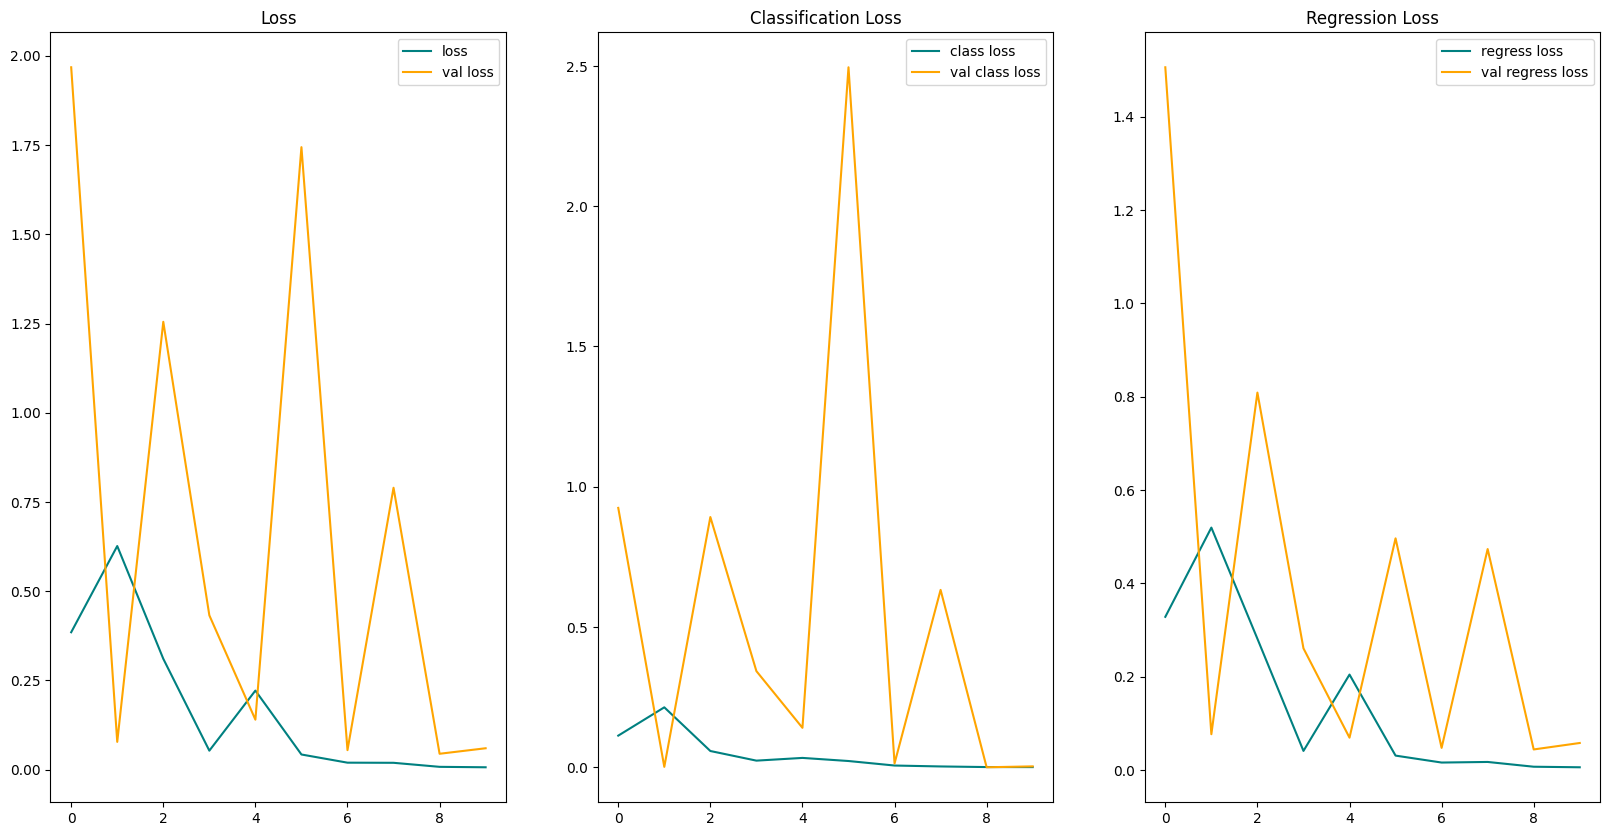

In [57]:
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(hist.history['total_loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_total_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['class_loss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_class_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Classification Loss')
ax[1].legend()

ax[2].plot(hist.history['regress_loss'], color='teal', label='regress loss')
ax[2].plot(hist.history['val_regress_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Regression Loss')
ax[2].legend()

plt.show()

In [58]:
test_data = test.as_numpy_iterator()
test_sample = test_data.next()
yhat = model(test_sample[0])


In [59]:
print(len(yhat))
print(yhat[0][0])
print(yhat[1][0])

2
tf.Tensor([0.99966097], shape=(1,), dtype=float32)
tf.Tensor([0.01296387 0.03686635 0.18498729 0.1478351 ], shape=(4,), dtype=float32)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


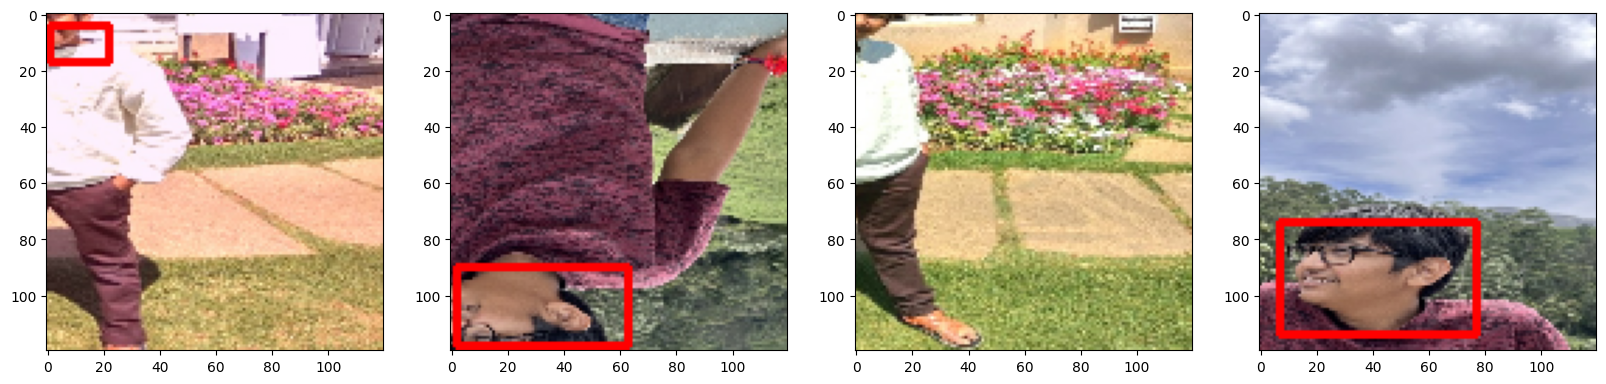

In [60]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = test_sample[0][idx]
    sample_coords = yhat[1][idx]
    
    if yhat[0][idx] > 0.9:
        cv2.rectangle(sample_image, 
                      tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                            (255,0,0), 2)
    
    ax[idx].imshow(sample_image)

In [61]:
model.model.save("./models/saved_model.keras")

In [ ]:
from keras.models import load_model
model = load_model("./models/saved_model.h5")

In [62]:
test_sample = test_data.next()
yhat = model(test_sample[0])

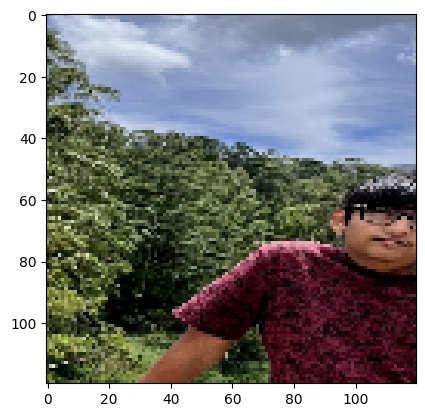

In [63]:
plt.imshow( test_sample[0][0])

In [64]:
# capture the bounded box around the face in test image
# use the bounded box to crop the image and save it in a folder named faces

# yhat[0] gives the probability of the image being a face
# yhat[1] gives the coordinates of the bounded box

def only_face(img):
    img=cv2.resize(img, (224,224))
    imgforinference= tf.image.resize(img, (120,120))
    imgforinference=tf.expand_dims(imgforinference, axis=0)
    yhat = model(imgforinference)
    if yhat[0][0] < 0.9:
        return None
    sample_coords = yhat[1][0]
    x1 = int(sample_coords[0]*224)
    y1 = int(sample_coords[1]*224)
    x2 = int(sample_coords[2]*224)
    y2 = int(sample_coords[3]*224)
    print(x1,y1,x2,y2)
    crop = img[y1:y2, x1:x2]
    # print(crop)
    plt.imshow(crop)
    crop = crop*255
    crop = crop.astype(np.uint8)
    crop=cv2.resize(crop, (224,224))
    return crop

157 99 221 163


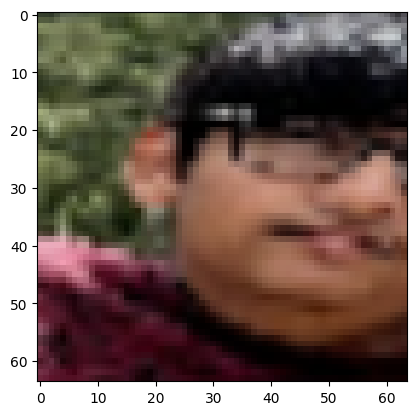

In [65]:
crop_img = only_face(test_sample[0][0])

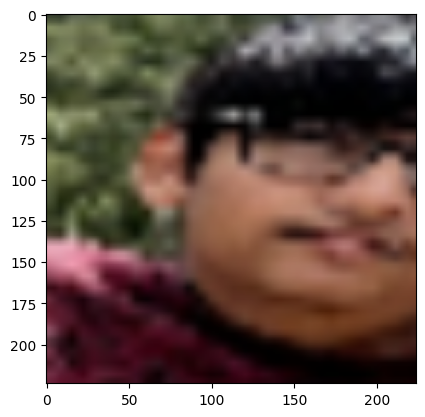

In [66]:
plt.imshow(crop_img)

In [83]:
def save_cropped_img(dataset,model):
    j=1
    while j<250:
        images=dataset.next()
        for i in range(len(images)):
            print(i)
            img = images[i]
            imgforinference= tf.image.resize(img, (120,120))
            imgforinference=tf.expand_dims(imgforinference, axis=0)
            yhat = model(imgforinference)
            if yhat[0][0] < 0.9:
                continue
            sample_coords = yhat[1][0]
            x1 = int(sample_coords[0]*1000)
            y1 = int(sample_coords[1]*1000)
            x2 = int(sample_coords[2]*1000)
            y2 = int(sample_coords[3]*1000)
            crop = img[y1:y2, x1:x2]
            print(crop)
            plt.imshow(crop)
            # crop = crop.numpy()
            crop = crop*255
            crop = crop.astype(np.uint8)
            crop = cv2.cvtColor(crop, cv2.COLOR_BGR2RGB)
            crop= cv2.resize(crop, (1000,1000))
            cv2.imwrite(os.path.join('cropped_faces','face3',f'{i+j}.jpg'),crop)
            j+=7

In [84]:
input_images = tf.data.Dataset.list_files('cam\\\images\\*.jpg', shuffle=False)
input_images = input_images.map(load_image)
input_images = input_images.map(lambda x: x/255)
input_images = input_images.map(lambda x: tf.image.resize(x, (1000,1000)))

In [85]:
input_images = input_images.batch(8)

In [86]:
input_images=input_images.as_numpy_iterator()

0
[[[0.92941177 0.9529412  0.94509804]
  [0.92941177 0.9529412  0.94509804]
  [0.92941177 0.9529412  0.94509804]
  ...
  [0.7375514  0.7493161  0.7218651 ]
  [0.7365475  0.74831223 0.72086126]
  [0.7344895  0.7462542  0.7188032 ]]

 [[0.93058825 0.95411766 0.9462745 ]
  [0.93058825 0.95411766 0.9462745 ]
  [0.93058825 0.95411766 0.9462745 ]
  ...
  [0.73607844 0.74784315 0.72039217]
  [0.7354746  0.7472393  0.7197883 ]
  [0.7337177  0.7454824  0.7180314 ]]

 [[0.93247056 0.956      0.94815683]
  [0.93247056 0.956      0.94815683]
  [0.93247056 0.956      0.94815683]
  ...
  [0.7341961  0.74596083 0.71850985]
  [0.7340063  0.745771   0.71832   ]
  [0.73345417 0.7452189  0.7177679 ]]

 ...

 [[0.2341178  0.23803937 0.31643623]
  [0.23099455 0.23491612 0.31227767]
  [0.22974741 0.2306104  0.3087844 ]
  ...
  [0.19749026 0.1973631  0.21309802]
  [0.19999988 0.19694106 0.21396065]
  [0.20250975 0.19945092 0.21647051]]

 [[0.23248786 0.23341207 0.31280178]
  [0.22996072 0.23082371 0.3102746 

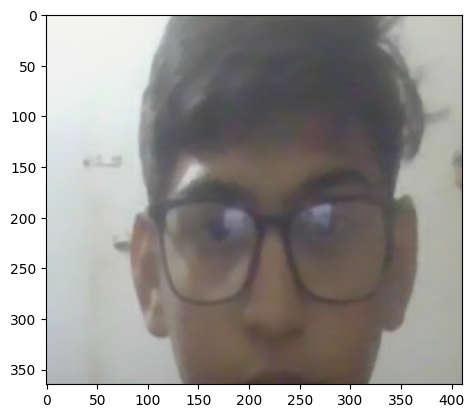

In [87]:
save_cropped_img(input_images,model)

In [ ]:
# Architecture for comparing Similarity in faces
# pipeline 1 -> take img -> detect face -> crop face -> save face in folder
# pipeline 2 -> take img -> detect face -> crop face -> save face in folder
# pipeline 3 -> add both pipelines and apply nn with sigmoid.

In [79]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    _ , frame = cap.read()
    frame = frame[50:500, 50:500,:]
    
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized = tf.image.resize(rgb, (120,120))
    
    yhat = model.predict(np.expand_dims(resized/255,0))
    sample_coords = yhat[1][0]
    
    if yhat[0] > 0.5: 
        # Controls the main rectangle
        cv2.rectangle(frame, 
                      tuple(np.multiply(sample_coords[:2], [450,450]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [450,450]).astype(int)), 
                            (255,0,0), 2)
        # Controls the label rectangle
        cv2.rectangle(frame, 
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int), 
                                    [0,-30])),
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                    [80,0])), 
                            (255,0,0), -1)
        
        # Controls the text rendered
        cv2.putText(frame, 'face', tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                               [0,-5])),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
    
    cv2.imshow('EyeTrack', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 83ms/step


In [88]:
!labelme

[INFO   ] __init__:get_config:70 - Loading config file from: C:\Users\hetar\.labelmerc
